# Feature engineering

In [1]:
import pandas as pd
import os
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
DATASET_DIR = "dataset" + os.sep

In [3]:
merged_df = pd.read_csv(DATASET_DIR + "merge_clean_v1.csv", parse_dates=["date"])
cyclist_df = pd.read_csv(DATASET_DIR + "cyclist_clean_v1.csv")
stages_df = pd.read_csv(DATASET_DIR + "stages_clean_v1.csv", parse_dates=["date"])

In [4]:
merged_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 589771 entries, 0 to 589770
Data columns (total 17 columns):
 #   Column             Non-Null Count   Dtype         
---  ------             --------------   -----         
 0   _url               589771 non-null  object        
 1   points             589771 non-null  int64         
 2   length             589771 non-null  float64       
 3   profile            475349 non-null  float64       
 4   startlist_quality  589771 non-null  int64         
 5   date               589771 non-null  datetime64[ns]
 6   position           589771 non-null  int64         
 7   cyclist            589771 non-null  object        
 8   cyclist_age        589658 non-null  float64       
 9   delta              589771 non-null  int64         
 10  race               589771 non-null  object        
 11  year               589771 non-null  int64         
 12  stage              589771 non-null  object        
 13  birth_year         589724 non-null  float64 

In [5]:
cyclist_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6095 entries, 0 to 6094
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   _url         6095 non-null   object 
 1   name         6095 non-null   object 
 2   birth_year   6084 non-null   float64
 3   weight       3134 non-null   float64
 4   height       3134 non-null   float64
 5   nationality  6095 non-null   object 
dtypes: float64(3), object(3)
memory usage: 285.8+ KB


In [6]:
stages_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5281 entries, 0 to 5280
Data columns (total 9 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   _url               5281 non-null   object        
 1   stage              5281 non-null   object        
 2   race               5281 non-null   object        
 3   date               5281 non-null   datetime64[ns]
 4   points             5281 non-null   int64         
 5   length             5281 non-null   int64         
 6   profile            3326 non-null   float64       
 7   startlist_quality  5281 non-null   int64         
 8   year               5281 non-null   int64         
dtypes: datetime64[ns](1), float64(1), int64(4), object(3)
memory usage: 371.4+ KB


## Feature creation

### Seasons

For features engineering we can discretize for example the date to extract the season (spring, winter ...) while for features novel we can create new feature to analyze in which seasons and in which years the cyclist is more active.

In [7]:
def get_season(date):
    month = date.month
    if month in [12, 1, 2]:
        return "Winter"
    elif month in [3, 4, 5]:
        return "Spring"
    elif month in [6, 7, 8]:
        return "Summer"
    elif month in [9, 10, 11]:
        return "Fall"


# Apply the function to the date column to create a new season column
merged_df["season"] = merged_df["date"].apply(get_season)
stages_df["season"] = stages_df["date"].apply(get_season)
stages_df.tail(10)

,_url,stage,race,date,points,length,profile,startlist_quality,year,season
5271,world-championship/2013/result,result,world-championship,2013-09-29,350,272200,2.0,1630,2013,Fall
5272,world-championship/2014/result,result,world-championship,2014-09-28,350,254800,2.0,1535,2014,Fall
5273,world-championship/2015/result,result,world-championship,2015-09-27,350,261400,3.0,1353,2015,Fall
5274,world-championship/2016/result,result,world-championship,2016-10-16,350,257300,1.0,998,2016,Fall
5275,world-championship/2017/result,result,world-championship,2017-09-24,350,267500,2.0,1327,2017,Fall
5276,world-championship/2018/result,result,world-championship,2018-09-30,350,258000,4.0,1374,2018,Fall
5277,world-championship/2019/result,result,world-championship,2019-09-29,350,260700,2.0,1443,2019,Fall
5278,world-championship/2020/result,result,world-championship,2020-09-27,350,258200,2.0,1008,2020,Fall
5279,world-championship/2021/result,result,world-championship,2021-09-26,350,268300,2.0,1357,2021,Fall
5280,world-championship/2022/result,result,world-championship,2022-09-25,350,266900,2.0,1052,2022,Fall


### Body density

In [8]:
cyclist_df["BMI"] = cyclist_df["weight"] / (cyclist_df["height"] / 100) ** 2
merged_df["BMI"] = merged_df["weight"] / (merged_df["height"] / 100) ** 2

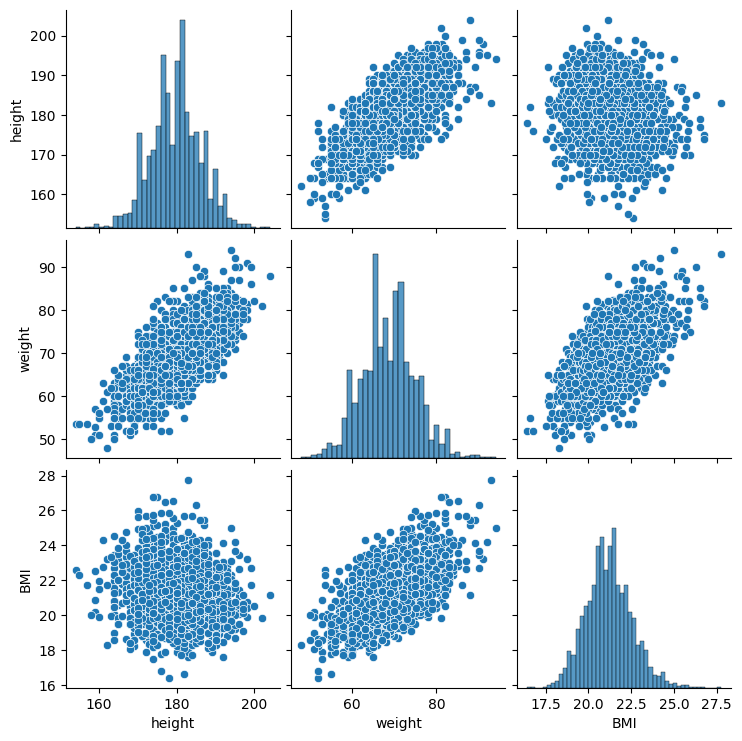

In [9]:
sns.pairplot(cyclist_df[["height", "weight", "BMI"]])

<Axes: >

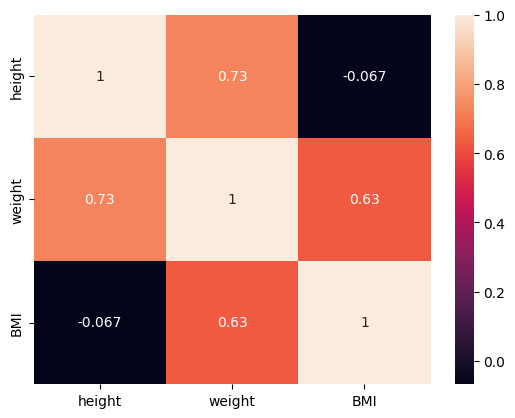

In [10]:
correlation_matrix = cyclist_df[["height", "weight", "BMI"]].corr()
sns.heatmap(correlation_matrix, annot=True)

Since weight higly correlated with both, I remove it

In [11]:
cyclist_df.drop(columns=["weight"], inplace=True)
merged_df.drop(columns=["weight"], inplace=True)

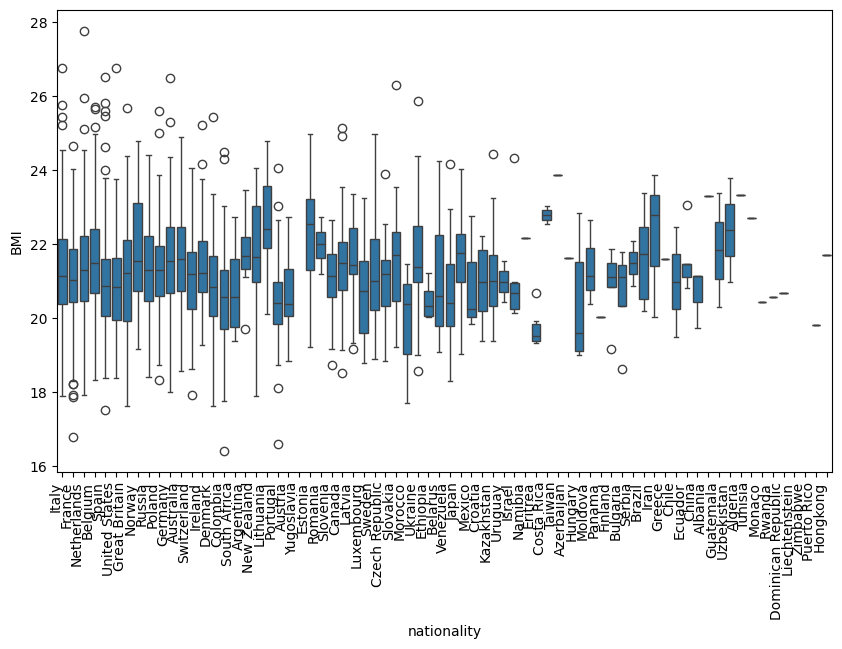

In [12]:
plt.figure(figsize=(10, 6))
sns.boxplot(x="nationality", y="BMI", data=cyclist_df)
plt.xticks(rotation=90, ha="right")
plt.show()

### Continent

Getting continent of each cyclist

In [13]:
countries = cyclist_df.nationality.unique()

In [14]:
import pycountry_convert as pc


def get_continent(country_name):
    if country_name == "Yugoslavia":
        return "Europe"
    elif country_name == "Hongkong":
        return "Asia"
    # print(country_name)
    country_alpha2 = pc.country_name_to_country_alpha2(country_name)
    country_continent_code = pc.country_alpha2_to_continent_code(country_alpha2)
    country_continent_name = pc.convert_continent_code_to_continent_name(
        country_continent_code
    )
    # print(f"{country_name} is in {country_continent_name}")
    return country_continent_name


cyclist_df["continent"] = cyclist_df["nationality"].apply(get_continent)
merged_df["continent"] = merged_df["nationality"].apply(get_continent)
cyclist_df.head()

,_url,name,birth_year,height,nationality,BMI,continent
0,bruno-surra,Bruno Surra,1964.0,NaN,Italy,NaN,Europe
1,gerard-rue,Gérard Rué,1965.0,182.0,France,22.340297,Europe
2,jan-maas,Jan Maas,1996.0,189.0,Netherlands,19.316369,Europe
3,nathan-van-hooydonck,Nathan Van Hooydonck,1995.0,192.0,Belgium,21.158854,Europe
4,jose-felix-parra,José Félix Parra,1997.0,171.0,Spain,18.809206,Europe


In [15]:
cyclist_df.continent.unique()
cyclist_df[cyclist_df["continent"].isna() & cyclist_df["nationality"].notna()]

,_url,name,birth_year,height,nationality,BMI,continent


## Anomaly Detection

### Cyclists

#### Outlier detection based on nationalities

In [16]:
# considering IQR to remove outliers
# The IQR is done grouping by nation as a first tentative

# threshold for which is ok to do outlier detection based on nationality
amount_threshold = 5

nationalities = cyclist_df.groupby("nationality")["_url"].size()
nationalities = nationalities[nationalities > amount_threshold]

filtered_cyclist_df = cyclist_df[cyclist_df["nationality"].isin(nationalities.index)]

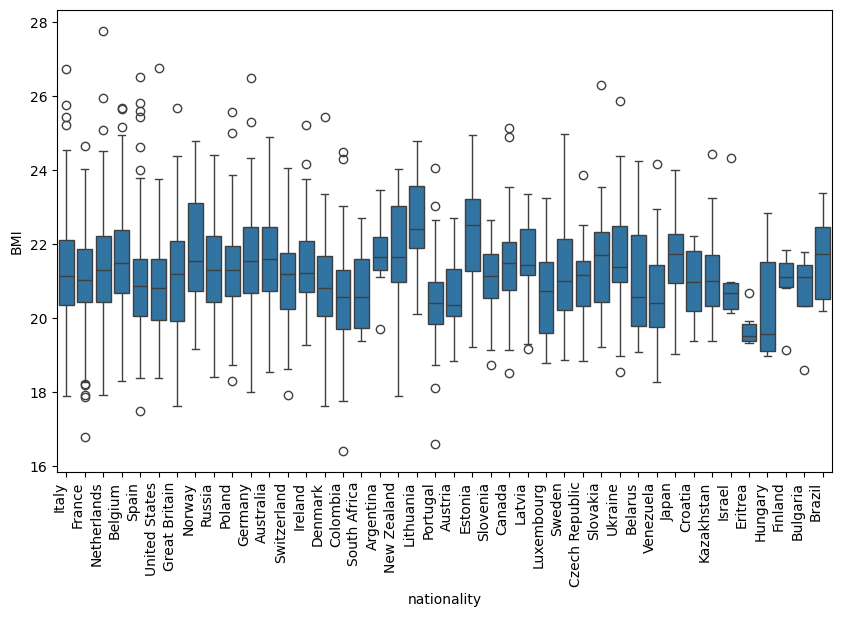

In [17]:
plt.figure(figsize=(10, 6))
sns.boxplot(x="nationality", y="BMI", data=filtered_cyclist_df)
plt.xticks(rotation=90, ha="right")
plt.show()

#### Outlier detection based on general distribution

In [18]:
Q1 = cyclist_df[["height", "BMI"]].quantile(0.25)
Q3 = cyclist_df[["height", "BMI"]].quantile(0.75)
IQR = Q3 - Q1
mask = (cyclist_df[["height", "BMI"]] > (Q1 - 1.5 * IQR)) & (
    cyclist_df[["height", "BMI"]] < (Q3 + 1.5 * IQR)
)
cyclist_no_outliers_df = cyclist_df[mask.all(axis=1)]
cyclist_no_outliers_df

,_url,name,birth_year,height,nationality,BMI,continent
1,gerard-rue,Gérard Rué,1965.0,182.0,France,22.340297,Europe
2,jan-maas,Jan Maas,1996.0,189.0,Netherlands,19.316369,Europe
3,nathan-van-hooydonck,Nathan Van Hooydonck,1995.0,192.0,Belgium,21.158854,Europe
4,jose-felix-parra,José Félix Parra,1997.0,171.0,Spain,18.809206,Europe
5,manuel-penalver,Manuel Peñalver,1998.0,177.0,Spain,21.385936,Europe
...,...,...,...,...,...,...,...
6086,santos-gonzalez,Santos González,1973.0,179.0,Spain,21.847009,Europe
6087,johannes-adamietz,Johannes Adamietz,1998.0,174.0,Germany,20.147972,Europe
6091,inigo-elosegui,Iñigo Elosegui,1998.0,188.0,Spain,21.220009,Europe
6093,jackson-rodriguez,Jackson Rodríguez,1985.0,170.0,Venezuela,20.069204,South America


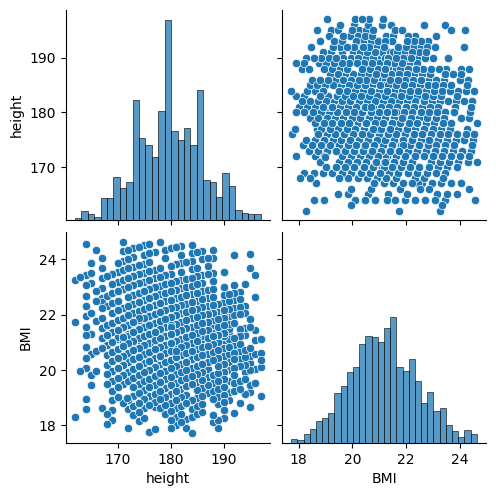

In [19]:
sns.pairplot(cyclist_no_outliers_df[["height", "BMI"]])

<Axes: ylabel='BMI'>

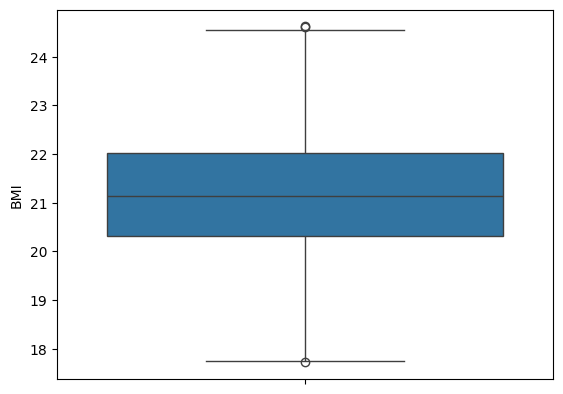

In [20]:
sns.boxplot(cyclist_no_outliers_df["BMI"])

### Stages

### Merge

## Data understanding

## Output datasets

In [21]:
cyclist_df.to_csv(DATASET_DIR + "cyclist_clean_v2.csv", index=False)
merged_df.to_csv(DATASET_DIR + "merge_clean_v2.csv", index=False)
stages_df.to_csv(DATASET_DIR + "stages_clean_v2.csv", index=False)